This notebook follows `munic_model_prod.ipynb`, where we ran the model. Here, we'll analyze and plot its results. So you don't have to understand the model to read this notebook, but if you're curious about it, please go ahead and read the other notebook!

Now, I could analyze the most important parameters in the model, what they mean and how this relates to the political science of Paris. But I'm not gonna do that -- at least not in a first draft of this analysis. As I want this notebook to be accessible to not-so-technical folks, I'll focus on vizualisations -- and as this model has hundreds of dimensions and parameters, I think it's also better than staring at a table of coefficients.

So, as usual, let's start by importing the necessary packages and defining handy helper functions:

In [1]:
%load_ext watermark

import arviz as az
import bokeh.plotting as bkp
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pymc3 as pm

from bokeh.io import output_notebook, show
from bokeh.layouts import column, gridplot
from bokeh.models import ColorBar, GeoJSONDataSource, HoverTool, LinearColorMapper
from bokeh.models.annotations import Title
from bokeh.models.widgets import Select
from bokeh.palettes import brewer, cividis
from bokeh.transform import linear_cmap
from scipy.special import softmax

SPAN_POLLS = 5
ALPHA_POLLS = 2 / (SPAN_POLLS + 1)
BINS = np.array([15.0, 25.0, 35.0, 45.0, 55.0, 65.0, 75.0])
CANDIDATES = {
    "Simonnet": "farleft",
    "Hidalgo": "left",
    "Belliard": "green",
    "Buzyn": "center",
    "Griveaux": "center",
    "Dati": "right",
    "Federbusch": "farright",
}
COLORS = {
    "farleft": np.array(brewer["Reds"][7][::-1]),
    "left": np.array(brewer["PuRd"][7][::-1]),
    "green": np.array(brewer["Greens"][7][::-1]),
    "center": np.array(brewer["Oranges"][7][::-1]),
    "right": np.array(brewer["Blues"][7][::-1]),
    "farright": np.array(brewer["Purples"][7][::-1]),
    "other": np.array(brewer["Greys"][7][::-1]),
}
MONTHS = {"janvier": 1, "février": 2, "mars": 3}
PARTIES = ["farleft", "left", "green", "center", "right", "farright", "other"]
Nparties = len(PARTIES) - 1
PARTIES_AGG = [
    "farleft_agg",
    "left_agg",
    "green_agg",
    "center_agg",
    "right_agg",
    "farright_agg",
]
RIGHT_POLLSTER = {
    "Harris Interactive": "Harris",
    "Ifop-Fiducial": "Ifop",
    "Ipsos-Sopra Steria": "Ipsos",
}

In [2]:
az.style.use("arviz-darkgrid")
output_notebook()


def compute_analyt_weights(df: pd.DataFrame) -> pd.DataFrame:

    pollster_ratings = pd.read_csv("../data/polls_1st_round/pollsters_weights.csv")
    df = pd.merge(
        df, pollster_ratings, how="left", left_on="pollster", right_on="sondage"
    )

    for p in PARTIES[:-1]:
        df[f"weightsondeur_{p}"].fillna(
            pollster_ratings[f"weightsondeur_{p}"].median(), inplace=True
        )
        df[f"analyt_weights_{p}"] = np.log(df.samplesize) * df[f"weightsondeur_{p}"]

    return df.set_index("date").sort_index()


def agg_polls(df: pd.DataFrame) -> pd.DataFrame:

    unique_dates = sorted(set(df.index))

    for p in PARTIES[:-1]:
        for i, d_outer in enumerate(unique_dates):
            for j, d_inner in enumerate(unique_dates[: i + 1]):
                df.loc[d_inner, f"expon_weights_{p}"] = (1 - ALPHA_POLLS) ** (i - j)

            df[f"final_weights_{p}"] = (
                df[f"analyt_weights_{p}"] * df[f"expon_weights_{p}"]
            )
            final_weights = df.loc[:d_outer, f"final_weights_{p}"]
            vote_share = df.loc[:d_outer, f"{p}"]

            df.loc[d_outer, f"{p}_agg"] = np.average(vote_share, weights=final_weights)

            # compute aggregate sample size only once:
            if p == "right":
                # same weights, whatever the party:
                expon_weights = df.loc[:d_outer, "expon_weights_right"]
                sample_size = df.loc[:d_outer, "samplesize"]
                df.loc[d_outer, "samplesize_agg"] = round(
                    np.average(sample_size, weights=expon_weights)
                )

    return df.reset_index()[
        ["date", "samplesize_agg"] + [f"{p}_agg" for p in PARTIES[:-1]]
    ]

Loading BokehJS ...

Now, let's load our MCMC samples and our data -- nothing really thrilling here:

In [3]:
with open("trace_prod.pkl", "rb") as f:
    data = pickle.load(f)
m_prod, trace_prod = data["model"], data["trace"]
idata = az.from_pymc3(trace_prod)
post = idata.posterior

unemp = pd.read_excel(
    "../data/predictors/chomage-zone-demploi-2003-2019.xls",
    header=5,
    sheet_name="txcho_ze",
)
unemp = unemp[unemp["LIBZE2010"] == "Paris"].iloc[:, 4:].T
unemp.columns = ["unemployment"]
unemp.index = pd.PeriodIndex(start=unemp.index[0], periods=len(unemp), freq="Q")

d = pd.read_csv("../data/whole_formatted_data.csv", index_col=0)
district_id, districts = d.arrondissement.factorize(sort=True)
Ndistricts = len(districts)

/Users/alex_andorra/opt/anaconda3/envs/fundfix/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Creating a PeriodIndex by passing range endpoints is deprecated.  Use `pandas.period_range` instead.
  


Here is something more fun: we're going to scrape the most recent polls from the appropriate [Wikipedia page](https://fr.wikipedia.org/wiki/%C3%89lections_municipales_de_2020_%C3%A0_Paris). Indeed, our model is trained on polls and unemployment data from previous elections. To get predictions for the coming city-council elections (March 15th, 2020), we need the last [unemployment figures in Paris](https://www.insee.fr/fr/statistiques/1893230) (most recent are for Q3 2019) and the last polls. Here is how the scraping of polls goes:

In [4]:
raw_polls = pd.read_html(
    "https://fr.wikipedia.org/wiki/%C3%89lections_municipales_de_2020_%C3%A0_Paris",
    attrs={"class": "wikitable centre"},
    match="Date de réalisation",
    decimal=",",
    thousands=" ",
    na_values=["—", "?"],
)[0]
raw_polls.columns = raw_polls.columns.droplevel([0, 2])
raw_polls = raw_polls[
    ~raw_polls.Source.str.contains("candidature | annonce | renonce")
].drop(["Gantzer", "Villani", "Bournazel", "Campion", "Berkani", "Autres"], axis=1)

# clean polls' characteristics:
raw_polls = raw_polls.rename(
    columns={
        "Source": "pollster",
        "Date de réalisation": "date",
        "Échantillon": "samplesize",
    }
)
raw_polls["pollster"] = raw_polls.pollster.replace(RIGHT_POLLSTER)
raw_polls["samplesize"] = raw_polls["samplesize"].str.split().str.join("").astype(int)

# take last field date:
field = raw_polls["date"].str.split(" au ", expand=True)[1].str.split(expand=True)
field.columns = ["day", "month"]
field["month"] = field["month"].replace(MONTHS)
field["year"] = 2020
raw_polls["date"] = pd.to_datetime(field[["day", "month", "year"]])

# clean candidates' values:
raw_polls[list(CANDIDATES.keys())] = raw_polls[CANDIDATES.keys()].astype(float)
raw_polls["Buzyn"] = raw_polls[["Buzyn", "Griveaux"]].fillna(0).sum(axis=1)
raw_polls = (
    raw_polls.drop("Griveaux", axis=1)
    .rename(columns=CANDIDATES)
    .sort_values("date")
    .dropna()
    .reset_index(drop=True)
)
raw_polls

,pollster,date,samplesize,farleft,left,green,center,right,farright
0,Ifop,2020-01-17,1102,5.0,25.0,14.0,15.0,19.0,5.0
1,Ifop,2020-01-17,1102,5.0,25.0,14.0,16.0,17.0,5.0
2,Odoxa,2020-01-20,1005,8.0,24.0,13.0,16.0,18.0,5.0
3,Odoxa,2020-01-23,1002,4.0,23.0,2.0,16.0,20.0,6.0
4,Ipsos,2020-02-19,1000,5.0,24.0,1.5,19.0,20.0,4.0
5,Harris,2020-02-19,1092,6.0,23.0,1.0,17.0,23.0,5.0
6,Odoxa,2020-02-19,809,7.0,23.0,1.0,17.0,25.0,4.0
7,Ifop,2020-02-21,976,6.0,24.0,12.0,19.0,22.0,3.5
8,Elabe,2020-02-28,1001,5.0,24.0,9.5,18.5,25.0,4.0
9,Ifop,2020-02-28,946,5.0,24.0,11.0,20.0,25.0,3.5


Pretty nice, uh? Yeah, pandas is awesome! Now, we're going to aggregate those polls by recency, sample size and historical performance of the pollster. This last weight is based on [a pollster ratings I computed](https://www.pollsposition.com/indicateurs/pollster_ratings) and updated with last year's polls (2019 European elections) -- I didn't have time to open-source this analysis yet, but hopefully one day I will! I'm not going to detail everything by writing, but you can see how it's done in the code of the two functions we defined at the beginning -- `compute_analyt_weights` and `agg_polls`. The code below also transforms the polls from their natural habitat ($[0, 1]$) to the real line ($[-\infty, +\infty]$. This is for technical reasons that I'm not going to detail here -- if you're curious, I explain everything in the notebook of the model.

In [5]:
oos_polls = compute_analyt_weights(raw_polls)
oos_polls = agg_polls(oos_polls).drop_duplicates()
# revert the softmax:
oos_polls[PARTIES_AGG] = oos_polls[PARTIES_AGG].div(100).apply(np.log) + 1
oos_polls.round(2)

,date,samplesize_agg,farleft_agg,left_agg,green_agg,center_agg,right_agg,farright_agg
0,2020-01-17,1102.0,-2.00,-0.39,-0.97,-0.86,-0.71,-2.00
2,2020-01-20,1060.0,-1.83,-0.40,-0.99,-0.85,-0.71,-2.00
3,2020-01-23,1038.0,-1.94,-0.43,-1.37,-0.84,-0.67,-1.92
4,2020-02-19,993.0,-1.87,-0.45,-2.28,-0.75,-0.55,-2.07
7,2020-02-21,989.0,-1.85,-0.44,-1.88,-0.73,-0.54,-2.11
8,2020-02-28,982.0,-1.91,-0.44,-1.57,-0.70,-0.47,-2.18


Ok, we're ready to make out-of-sample predictions! This is going to look weird and esoteric, but I'm actually just taking each parameters for the couples (district, party) and pushing them through the model to get the posterior probabilities of each party, in each district -- this will make more sense when we get to the vizualization part.

In [6]:
last_unemployment = (
    (np.log(unemp.iloc[-1]) - np.log(d["unemployment"]).mean())
    / np.log(d["unemployment"]).std()
).iloc[0]

# extract posterior std of noise:
noisy_mus_sd = az.summary(trace_prod, round_to=2, var_names=["noisy_mus"])["sd"]
post_sd_noisy_mus = []
for p in range(Nparties):
    post_sd_noisy_mus.append(
        noisy_mus_sd.loc[[f"noisy_mus[{idx},{p}]" for idx in range(trace_prod["noisy_mus"].shape[1])]].mean()
    )
post_sd_noisy_mus = np.asarray(post_sd_noisy_mus)

# push parameters through the model:
post_preds = []
for p_id, p in enumerate(PARTIES_AGG):
    last_polls = (oos_polls.iloc[-1][p] - d[p].mean()) / d[p].std()

    post_preds.append(
        trace_prod[f"β_district_p{p_id}"][:, :, 0]
        + trace_prod[f"type_effect_p{p_id}"][:, 2, None]
        + trace_prod[f"β_district_p{p_id}"][:, :, 1] * last_unemployment
        + trace_prod[f"β_district_p{p_id}"][:, :, 2] * last_polls
    )
    
post_preds = np.asarray(post_preds).T
noisy_post_preds = post_preds + pm.Normal.dist(
    mu=[0.0] * Nparties, sigma=post_sd_noisy_mus
).random(size=post_preds.shape[0:2])
noisy_post_preds.shape

(20, 8000, 6)

In [7]:
vary_pivot = pm.Normal.dist(mu=-3.0, sigma=0.05).random(
    size=(Ndistricts, post_preds.shape[1], 1)
)
noisy_post_preds = np.c_[noisy_post_preds, vary_pivot]
noisy_post_preds.shape

(20, 8000, 7)

In [8]:
share_est = softmax(noisy_post_preds, axis=2) * 100
share_mean = share_est.mean(1)
share_est.shape

(20, 8000, 7)

Now that we have the data, it's time to plot them! The following code displays the model's estimation of how each party's strength in each district. The yellow points are the mean estimates, and the blue bars are the 94% compatibility interval -- in the small world of the model, there is a 94% chance that the true result will fall in this range; of course, a model is a reduction of reality, so there usually is more uncertainty than just the one the model tells us about. But it should be a good rule of thumb (if I did a good job!) and it allows us to compare the uncertainty across districts and parties:

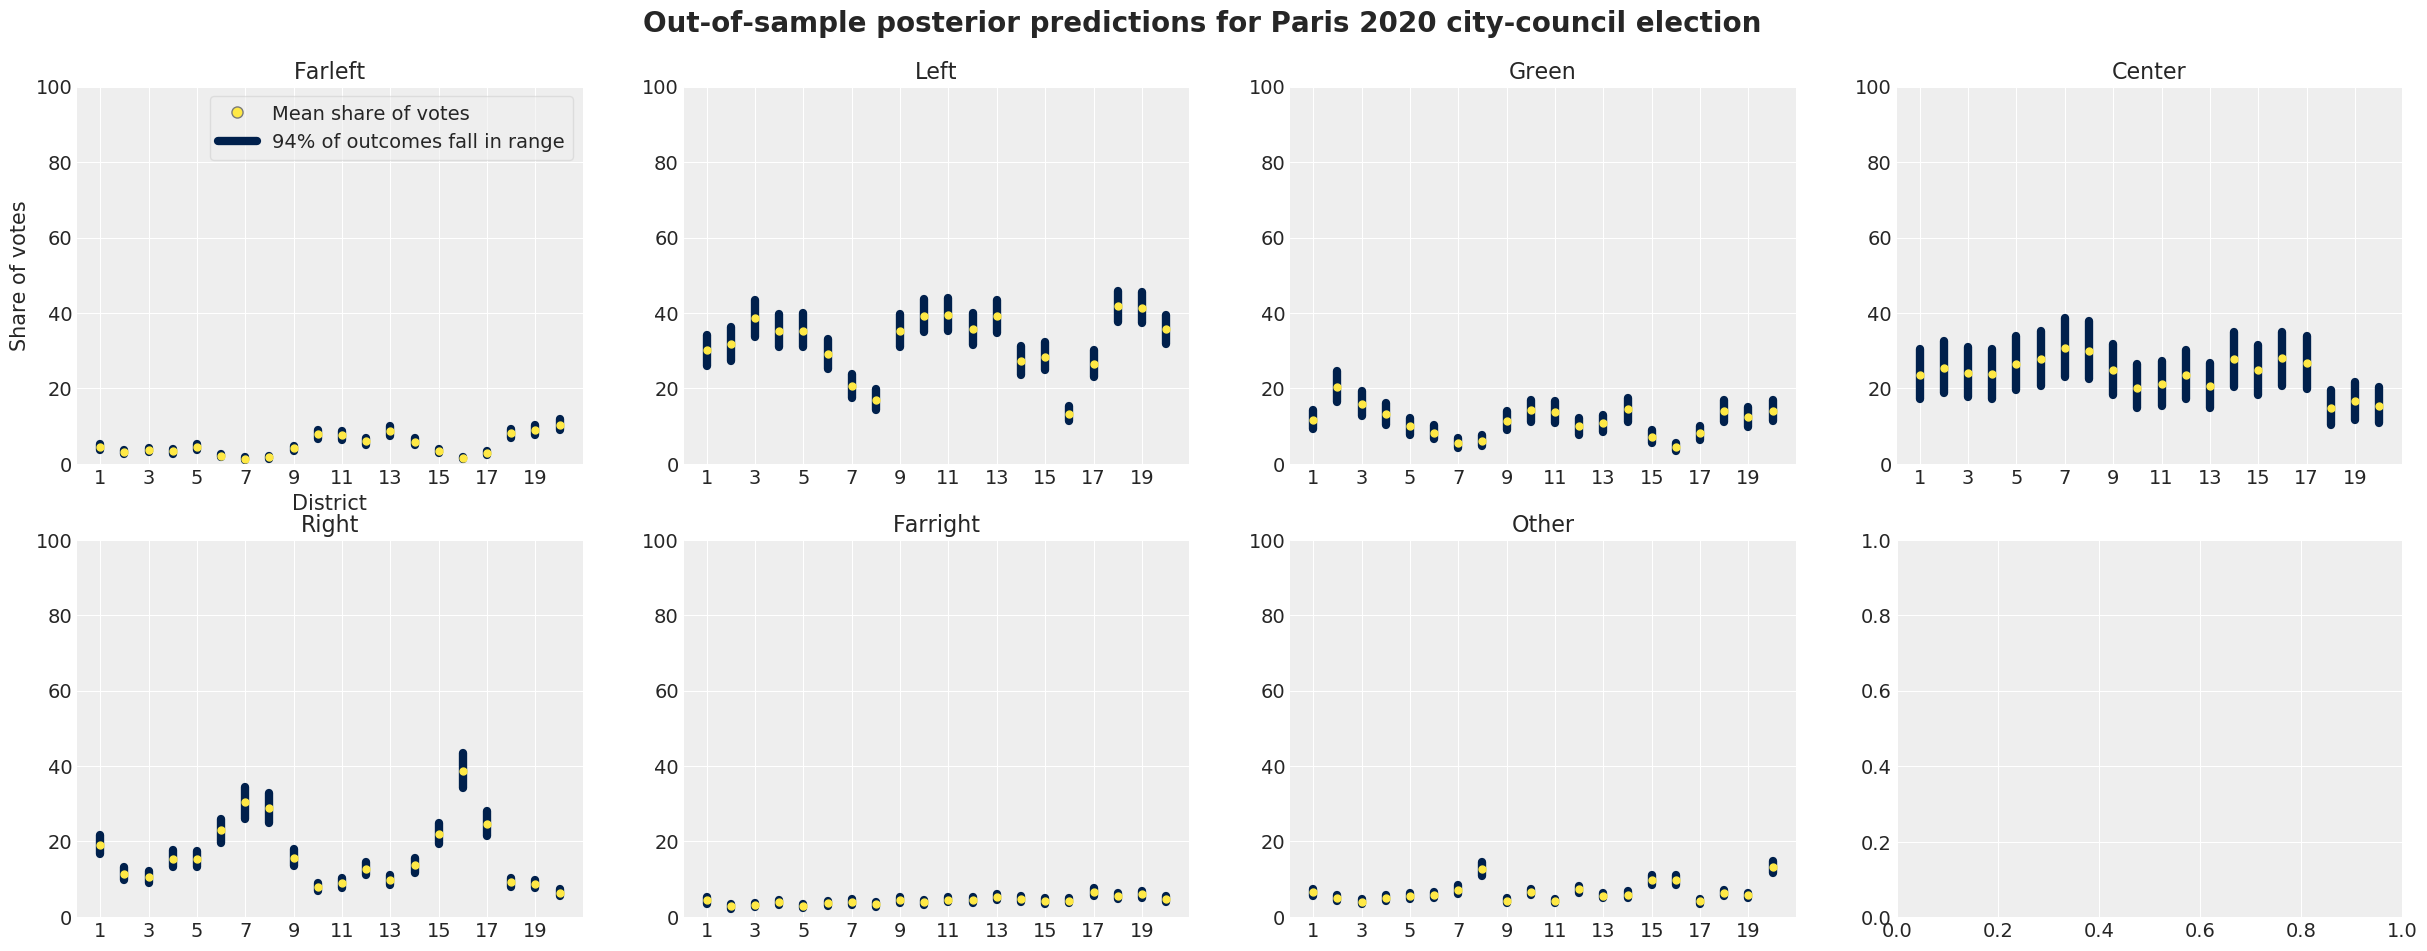

In [9]:
fig, axes = plt.subplots(2, 4, figsize=(30, 11))
for i, ax in enumerate(axes.flat):
    try:
        ax.plot(
            [np.arange(Ndistricts), np.arange(Ndistricts)],
            az.hpd(share_est[:, :, i].T).T,
            color=cividis(3)[0],
            lw=6,
        )
        ax.plot(
            np.arange(Ndistricts), share_mean[:, i], "o", color=cividis(3)[2], ms=5,
        )
        ax.set_xticks(range(Ndistricts)[::2])
        ax.set_xticklabels(range(1, Ndistricts + 1)[::2])
        ax.set_title(f"{PARTIES[i].title()}")
        ax.set_ylim([-0.05, 100.0])
        if i == 0:
            ax.set_xlabel("District")
            ax.set_ylabel("Share of votes")
            ax.plot(
                [],
                "o",
                markeredgecolor=cividis(3)[1],
                markeredgewidth=1,
                color=cividis(3)[2],
                ms=8,
                label="Mean share of votes",
            )
            ax.plot(
                [], label="94% of outcomes fall in range", color=cividis(2)[0], lw=6
            )
            ax.legend(frameon=True, framealpha=0.5)
    except IndexError:
        continue
fig.suptitle(
    "Out-of-sample posterior predictions for Paris 2020 city-council election",
    y=0.95,
    size=20,
    weight="bold",
);

We already see the big favorites: left, center and right, by descending order. The centrist party is the one with the biggest uncertainty. I think this is mostly due to the fact that this party was a semi-fringe one before 2017 and Emmanuel Macron. So, we don't have a lot of data to estimate its chances -- just think that for the last city-council elections, in 2014, the centrist party was so weak that they didn't compete; and now, it's the president's party, which accounts for a sizeable share of the electorate, especially in Paris. 

I'll expand a little on this analysis in future iterations of this notebook, but for now let's plot the model's expectations on a map of Paris! This is done by the code below. I want to sincerely thank Grégoire David for [his awesome open-source project, france-geojson](https://github.com/gregoiredavid/france-geojson), where I found the geographic shapes of Paris.

In [10]:
win_summary = {}
for district in range(Ndistricts):
    district_shares = share_est[district]
    district_means = share_mean[district]
    district_hpds = az.hpd(district_shares)

    # compute winner in each simulation:
    order = np.squeeze(np.argsort(-district_shares, axis=1)[:, :1])
    winners = pd.Series(order)

    probs = pd.DataFrame(
        winners.value_counts(normalize=True).multiply(100).round().astype(int)
    )
    probs.columns = ["odds"]
    probs["low"], probs["high"], probs["mean"] = np.nan, np.nan, np.nan

    for p_id in probs.index:
        probs.loc[p_id, "low"], probs.loc[p_id, "high"] = district_hpds[p_id]
        probs.loc[p_id, "mean"] = district_means[p_id]
        # assign means to color bins:
        bins_idx = np.digitize(probs.loc[p_id, "mean"], BINS)
        probs.loc[p_id, "color"] = COLORS[PARTIES[p_id]][bins_idx]
    probs.index = np.array(PARTIES)[probs.index]
    probs.index.name = "winner"
    win_summary[district] = probs.reset_index()

win_summary = pd.concat(win_summary).reset_index(level=1)
# keep only most probable winner:
win_summary = (
    win_summary[win_summary.level_1 == 0].drop("level_1", axis=1).set_index(districts)
)

In [11]:
paris_shape = (
    gpd.read_file("../data/paris_shape.json")
    .sort_values("code")
    .reset_index(drop=True)
    .set_index(districts)
)
paris_shape = pd.concat([paris_shape, win_summary], axis=1).reset_index()
paris_shape["winner"] = paris_shape["winner"].str.title()
geosource = GeoJSONDataSource(geojson=paris_shape.to_json())
paris_shape.head()

,index,code,nom,geometry,winner,odds,low,high,mean,color
0,1,75101,Paris 1er Arrondissement,"POLYGON ((2.32576 48.86955, 2.32787 48.86986, ...",Left,89,26.064916,34.152793,30.200551,#c994c7
1,2,75102,Paris 2e Arrondissement,"POLYGON ((2.35084 48.86334, 2.32787 48.86986, ...",Left,87,27.400362,36.265183,31.748253,#c994c7
2,3,75103,Paris 3e Arrondissement,"POLYGON ((2.35009 48.86195, 2.35084 48.86334, ...",Left,99,33.654032,43.397001,38.602575,#df65b0
3,4,75104,Paris 4e Arrondissement,"POLYGON ((2.34456 48.85399, 2.35009 48.86195, ...",Left,98,30.969567,39.818098,35.196478,#df65b0
4,5,75105,Paris 5e Arrondissement,"POLYGON ((2.34456 48.85399, 2.36432 48.84617, ...",Left,93,30.915991,39.912706,35.348270,#df65b0


In [12]:
p = bkp.figure(
    title="Predictions by district for Paris 2020 city-council election",
    align="center",
    plot_height=350,
    plot_width=600,
    sizing_mode="scale_both",
    title_location="above",
    tools="",
    toolbar_location=None,
)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.axis.visible = False
p.outline_line_color = None
p.title.align = "center"
p.title.text_font_size = "1.4rem"
p.background_fill_color = "#e6e6e6"
p.border_fill_color = "#e6e6e6"

palette = COLORS["other"]
color_mapper = LinearColorMapper(palette=palette, low=0, high=75)
# custom tick labels for color bar:
tick_labels = {
    "0": "0",
    "10": "15",
    "20": "25",
    "30": "35",
    "40": "45",
    "50": "55",
    "60": "65",
    "70": "75+% of votes",
}
color_bar = ColorBar(
    background_fill_color="#e6e6e6",
    border_line_color=None,
    color_mapper=color_mapper,
    height=400,
    label_standoff=18,
    major_label_overrides=tick_labels,
    orientation="vertical",
    padding=0,
    title="7 Shades of Grey",
    title_standoff=4,
    width=20,
)
# TO DO: LEGEND
# http://docs.bokeh.org/en/latest/docs/reference/models/annotations.html?highlight=legend#bokeh.models.annotations.Legend
# https://docs.bokeh.org/en/latest/docs/user_guide/styling.html#legends
# https://docs.bokeh.org/en/latest/docs/user_guide/categorical.html
# https://stackoverflow.com/questions/54826102/bokeh-how-to-add-legend-to-patches-glyph-with-geojsondatasource-and-categorical

district_shapes = p.patches(
    "xs",
    "ys",
    source=geosource,
    fill_color="color",
    fill_alpha=1,
    line_color="gray",
    line_width=0.75,
)
p.add_tools(
    HoverTool(
        renderers=[district_shapes],
        tooltips=[
            ("", "Paris, District @index"),
            ("Winner", "@winner, with @odds% chance"),
            ("Mean", "@mean{1.1} %"),
            ("94% HPD", "[@low{1.1} - @high{1.1}] % of votes"),
        ],
    )
)
p.add_layout(color_bar, "right")
show(p)

Lots of information on this map! The color of each district indicates who is the projected winner -- here, only the right (blue), center (orange) and left (pink) parties are expected to win districts. In addition, each party's color is declined in shades. As indicated by the color bar to the right, the darker the color, the bigger the expected vote share for the party in the district. The center and right parties are displayed in only one shades, which means their support is about the same in the corresponding districts. However, the Socialist party is stronger on the East side of Paris -- where it's mostly a huge favorite -- than in the center -- where its probabilities of winning are much slimmer and closer to the centrist party. 

Finally, you have all this detailed information when hovering over the districts: the expected winner of the district and its associated probability; the mean vote share; the 94% compatibility interval of vote shares.

More can be said about this map alone, but that will be for a later iteration of this notebook -- so, come back for more! Hope you enjoyed this notebook, and feel free to reach out for comments, suggestions and ideas!

In [13]:
%watermark -a AlexAndorra -n -u -v -iv

arviz     0.6.1
pandas    0.25.3
geopandas 0.6.1
numpy     1.17.3
pymc3     3.8
AlexAndorra 
last updated: Wed Mar 04 2020 

CPython 3.7.0
IPython 7.12.0
